In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications import DenseNet201
from keras.applications import DenseNet121

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [8]:
    train_dir = 'data/kaggle_histo/train/'
test_dir = "data/kaggle_histo/test/"

extracted_features_dir = "extracted_features/"
model_name = "kaggle_InceptionV3"

In [9]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.10.0
dim_ordering: tf


In [10]:
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 1000

In [11]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/kaggle_histo/train/ 0
data/kaggle_histo/train/cancer 256400
data/kaggle_histo/train/normal 375900
******************************
data/kaggle_histo/test/ 0
data/kaggle_histo/test/cancer 6368
data/kaggle_histo/test/normal 9376


In [12]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 474225 images belonging to 2 classes.
Found 158075 images belonging to 2 classes.
Found 15744 images belonging to 2 classes.


In [13]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
# predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
# print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
# print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 474225
nb_validation_samples: 158075

predict_size_train: 14820
predict_size_validation: 4940
nb_test_samples: 15744
predict_size_test: 492

 num_classes: 2


In [14]:
# from keras.backend.tensorflow_backend import get_session
# from keras.backend.tensorflow_backend import clear_session
# from keras.backend.tensorflow_backend import set_session

# def reset_keras_tf_session():
#     """
#     this function clears the gpu memory and set the 
#     tf session to not use the whole gpu
#     """
#     sess = get_session()
#     clear_session()
#     sess.close()
#     sess = get_session()

# #     config = tf.ConfigProto()
# #     config.gpu_options.allow_growth = True
# #     set_session(tf.Session(config=config))


# reset_keras_tf_session()

In [15]:
# from keras.applications.mobilenetv2 import MobileNetV2
# from keras.applications.densenet import DenseNet169
# from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
# from keras.applications.vgg16 import VGG16
# from keras.applications.xception import Xception, preprocess_input
# from keras.applications import DenseNet201
# from keras.applications import DenseNet121
# from keras.applications import ResNet50
# from keras.applications.inception_resnet_v2 import InceptionResNetV2
# from keras.applications import NASNetLarge, NASNetMobile
# from keras.applications import MobileNet

In [16]:
input_tensor = Input(shape = input_shape)  
model = InceptionV3(weights='imagenet', include_top=False, pooling = 'avg', input_tensor=input_tensor)
bottleneck_final_model = model

In [17]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [18]:
# c1 = model.layers[4].output 
# c1 = GlobalAveragePooling2D()(c1)       

# c2 = model.layers[7].output
# c2 = GlobalAveragePooling2D()(c2)       

# c3 = model.layers[12].output
# c3 = GlobalAveragePooling2D()(c3)       

# c4 = model.layers[17].output
# c4 = GlobalAveragePooling2D()(c4)

# con = concatenate([c1, c2, c4])

# bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [19]:
# bottleneck_final_model.summary()

In [20]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [21]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [22]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [23]:
dropout_rate = 0.4

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.0001, beta_1=0.6, beta_2=0.9, amsgrad=False)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 474225 samples, validate on 158075 samples
Epoch 1/1000
 - 49s - loss: 0.3669 - acc: 0.8386 - val_loss: 0.3268 - val_acc: 0.8584
Epoch 2/1000
 - 48s - loss: 0.3374 - acc: 0.8557 - val_loss: 0.3171 - val_acc: 0.8641
Epoch 3/1000
 - 48s - loss: 0.3279 - acc: 0.8616 - val_loss: 0.3146 - val_acc: 0.8686
Epoch 4/1000
 - 48s - loss: 0.3223 - acc: 0.8653 - val_loss: 0.3136 - val_acc: 0.8702
Epoch 5/1000
 - 48s - loss: 0.3183 - acc: 0.8686 - val_loss: 0.3078 - val_acc: 0.8726
Epoch 6/1000
 - 48s - loss: 0.3155 - acc: 0.8701 - val_loss: 0.3122 - val_acc: 0.8719
Epoch 7/1000
 - 48s - loss: 0.3131 - acc: 0.8722 - val_loss: 0.3207 - val_acc: 0.8709
Epoch 8/1000
 - 48s - loss: 0.3112 - acc: 0.8738 - val_loss: 0.3095 - val_acc: 0.8746
Epoch 9/1000
 - 48s - loss: 0.3095 - acc: 0.8754 - val_loss: 0.3084 - val_acc: 0.8758
Epoch 10/1000
 - 48s - loss: 0.3085 - acc: 0.8764 - val_loss: 0.3129 - val_acc: 0.8768
Epoch 11/1000
 - 48s - loss: 0.3073 - acc: 0.8768 - val_loss: 0.3114 - val_acc: 0.8761


Epoch 95/1000
 - 48s - loss: 0.3100 - acc: 0.8905 - val_loss: 0.3747 - val_acc: 0.8723
Epoch 96/1000
 - 48s - loss: 0.3092 - acc: 0.8906 - val_loss: 0.3779 - val_acc: 0.8747
Epoch 97/1000
 - 48s - loss: 0.3117 - acc: 0.8902 - val_loss: 0.3791 - val_acc: 0.8741
Epoch 98/1000
 - 48s - loss: 0.3112 - acc: 0.8906 - val_loss: 0.3760 - val_acc: 0.8753
Epoch 99/1000
 - 48s - loss: 0.3111 - acc: 0.8905 - val_loss: 0.3749 - val_acc: 0.8735
Epoch 100/1000
 - 48s - loss: 0.3113 - acc: 0.8907 - val_loss: 0.3830 - val_acc: 0.8747
Epoch 101/1000
 - 48s - loss: 0.3114 - acc: 0.8903 - val_loss: 0.3841 - val_acc: 0.8737
Epoch 102/1000
 - 48s - loss: 0.3122 - acc: 0.8905 - val_loss: 0.3840 - val_acc: 0.8736
Epoch 103/1000
 - 48s - loss: 0.3123 - acc: 0.8906 - val_loss: 0.3844 - val_acc: 0.8739
Epoch 104/1000
 - 48s - loss: 0.3133 - acc: 0.8903 - val_loss: 0.3857 - val_acc: 0.8734
Epoch 105/1000
 - 48s - loss: 0.3138 - acc: 0.8906 - val_loss: 0.3862 - val_acc: 0.8736
Epoch 106/1000
 - 48s - loss: 0.3133 

 - 48s - loss: 0.3279 - acc: 0.8906 - val_loss: 0.4167 - val_acc: 0.8696
Epoch 189/1000
 - 48s - loss: 0.3280 - acc: 0.8898 - val_loss: 0.4276 - val_acc: 0.8713
Epoch 190/1000
 - 48s - loss: 0.3289 - acc: 0.8899 - val_loss: 0.4180 - val_acc: 0.8698
Epoch 191/1000
 - 48s - loss: 0.3271 - acc: 0.8897 - val_loss: 0.4229 - val_acc: 0.8699
Epoch 192/1000
 - 48s - loss: 0.3275 - acc: 0.8898 - val_loss: 0.4206 - val_acc: 0.8701
Epoch 193/1000
 - 48s - loss: 0.3282 - acc: 0.8900 - val_loss: 0.4234 - val_acc: 0.8694
Epoch 194/1000
 - 48s - loss: 0.3285 - acc: 0.8897 - val_loss: 0.4241 - val_acc: 0.8708
Epoch 195/1000
 - 48s - loss: 0.3297 - acc: 0.8895 - val_loss: 0.4272 - val_acc: 0.8706
Epoch 196/1000
 - 48s - loss: 0.3291 - acc: 0.8894 - val_loss: 0.4341 - val_acc: 0.8708
Epoch 197/1000
 - 48s - loss: 0.3288 - acc: 0.8896 - val_loss: 0.4340 - val_acc: 0.8703
Epoch 198/1000
 - 48s - loss: 0.3294 - acc: 0.8897 - val_loss: 0.4348 - val_acc: 0.8709
Epoch 199/1000
 - 48s - loss: 0.3305 - acc: 0.8

Epoch 282/1000
 - 47s - loss: 0.3412 - acc: 0.8879 - val_loss: 0.4475 - val_acc: 0.8666
Epoch 283/1000
 - 48s - loss: 0.3409 - acc: 0.8880 - val_loss: 0.4579 - val_acc: 0.8678
Epoch 284/1000
 - 48s - loss: 0.3408 - acc: 0.8884 - val_loss: 0.4589 - val_acc: 0.8681
Epoch 285/1000
 - 48s - loss: 0.3409 - acc: 0.8880 - val_loss: 0.4533 - val_acc: 0.8669
Epoch 286/1000
 - 48s - loss: 0.3412 - acc: 0.8876 - val_loss: 0.4517 - val_acc: 0.8676
Epoch 287/1000
 - 48s - loss: 0.3422 - acc: 0.8876 - val_loss: 0.4553 - val_acc: 0.8674
Epoch 288/1000
 - 47s - loss: 0.3414 - acc: 0.8878 - val_loss: 0.4628 - val_acc: 0.8670
Epoch 289/1000
 - 48s - loss: 0.3431 - acc: 0.8880 - val_loss: 0.4537 - val_acc: 0.8675
Epoch 290/1000
 - 47s - loss: 0.3419 - acc: 0.8879 - val_loss: 0.4622 - val_acc: 0.8681
Epoch 291/1000
 - 48s - loss: 0.3425 - acc: 0.8873 - val_loss: 0.4632 - val_acc: 0.8680
Epoch 292/1000
 - 47s - loss: 0.3430 - acc: 0.8878 - val_loss: 0.4518 - val_acc: 0.8679
Epoch 293/1000
 - 48s - loss: 0.

 - 47s - loss: 0.3547 - acc: 0.8864 - val_loss: 0.4770 - val_acc: 0.8671
Epoch 376/1000
 - 48s - loss: 0.3541 - acc: 0.8864 - val_loss: 0.4795 - val_acc: 0.8659
Epoch 377/1000
 - 48s - loss: 0.3549 - acc: 0.8865 - val_loss: 0.4777 - val_acc: 0.8660
Epoch 378/1000
 - 47s - loss: 0.3555 - acc: 0.8864 - val_loss: 0.4886 - val_acc: 0.8663
Epoch 379/1000
 - 47s - loss: 0.3559 - acc: 0.8865 - val_loss: 0.4796 - val_acc: 0.8654
Epoch 380/1000
 - 47s - loss: 0.3562 - acc: 0.8863 - val_loss: 0.4746 - val_acc: 0.8654
Epoch 381/1000
 - 48s - loss: 0.3551 - acc: 0.8859 - val_loss: 0.4880 - val_acc: 0.8665
Epoch 382/1000
 - 47s - loss: 0.3567 - acc: 0.8861 - val_loss: 0.4811 - val_acc: 0.8663
Epoch 383/1000
 - 47s - loss: 0.3540 - acc: 0.8862 - val_loss: 0.4788 - val_acc: 0.8667
Epoch 384/1000
 - 47s - loss: 0.3542 - acc: 0.8866 - val_loss: 0.4840 - val_acc: 0.8661
Epoch 385/1000
 - 47s - loss: 0.3550 - acc: 0.8861 - val_loss: 0.4746 - val_acc: 0.8661
Epoch 386/1000
 - 48s - loss: 0.3555 - acc: 0.8

Epoch 469/1000
 - 47s - loss: 0.3670 - acc: 0.8847 - val_loss: 0.5000 - val_acc: 0.8651
Epoch 470/1000
 - 47s - loss: 0.3656 - acc: 0.8848 - val_loss: 0.5031 - val_acc: 0.8651
Epoch 471/1000
 - 47s - loss: 0.3662 - acc: 0.8851 - val_loss: 0.5015 - val_acc: 0.8641
Epoch 472/1000
 - 48s - loss: 0.3674 - acc: 0.8848 - val_loss: 0.5023 - val_acc: 0.8646
Epoch 473/1000
 - 47s - loss: 0.3676 - acc: 0.8851 - val_loss: 0.5097 - val_acc: 0.8652
Epoch 474/1000
 - 48s - loss: 0.3675 - acc: 0.8851 - val_loss: 0.5041 - val_acc: 0.8640
Epoch 475/1000
 - 48s - loss: 0.3654 - acc: 0.8849 - val_loss: 0.5032 - val_acc: 0.8637
Epoch 476/1000
 - 48s - loss: 0.3677 - acc: 0.8849 - val_loss: 0.4960 - val_acc: 0.8639
Epoch 477/1000
 - 48s - loss: 0.3666 - acc: 0.8847 - val_loss: 0.4973 - val_acc: 0.8635
Epoch 478/1000
 - 48s - loss: 0.3663 - acc: 0.8848 - val_loss: 0.4989 - val_acc: 0.8646
Epoch 479/1000
 - 47s - loss: 0.3659 - acc: 0.8848 - val_loss: 0.5071 - val_acc: 0.8649
Epoch 480/1000
 - 48s - loss: 0.

 - 48s - loss: 0.3764 - acc: 0.8838 - val_loss: 0.5202 - val_acc: 0.8631
Epoch 563/1000
 - 48s - loss: 0.3778 - acc: 0.8836 - val_loss: 0.5157 - val_acc: 0.8633
Epoch 564/1000
 - 48s - loss: 0.3763 - acc: 0.8841 - val_loss: 0.5229 - val_acc: 0.8631
Epoch 565/1000
 - 48s - loss: 0.3764 - acc: 0.8835 - val_loss: 0.5199 - val_acc: 0.8630
Epoch 566/1000
 - 48s - loss: 0.3779 - acc: 0.8834 - val_loss: 0.5215 - val_acc: 0.8633
Epoch 567/1000
 - 48s - loss: 0.3766 - acc: 0.8839 - val_loss: 0.5244 - val_acc: 0.8637
Epoch 568/1000
 - 48s - loss: 0.3780 - acc: 0.8835 - val_loss: 0.5175 - val_acc: 0.8629
Epoch 569/1000
 - 48s - loss: 0.3768 - acc: 0.8838 - val_loss: 0.5236 - val_acc: 0.8638
Epoch 570/1000
 - 48s - loss: 0.3780 - acc: 0.8835 - val_loss: 0.5198 - val_acc: 0.8630
Epoch 571/1000
 - 47s - loss: 0.3783 - acc: 0.8838 - val_loss: 0.5257 - val_acc: 0.8630
Epoch 572/1000
 - 47s - loss: 0.3792 - acc: 0.8837 - val_loss: 0.5217 - val_acc: 0.8631
Epoch 573/1000
 - 48s - loss: 0.3780 - acc: 0.8

Epoch 656/1000
 - 47s - loss: 0.3883 - acc: 0.8825 - val_loss: 0.5398 - val_acc: 0.8625
Epoch 657/1000
 - 47s - loss: 0.3883 - acc: 0.8823 - val_loss: 0.5373 - val_acc: 0.8626
Epoch 658/1000
 - 47s - loss: 0.3883 - acc: 0.8824 - val_loss: 0.5371 - val_acc: 0.8626
Epoch 659/1000
 - 47s - loss: 0.3887 - acc: 0.8826 - val_loss: 0.5424 - val_acc: 0.8625
Epoch 660/1000
 - 47s - loss: 0.3881 - acc: 0.8829 - val_loss: 0.5450 - val_acc: 0.8631
Epoch 661/1000
 - 48s - loss: 0.3887 - acc: 0.8838 - val_loss: 0.5423 - val_acc: 0.8623
Epoch 662/1000
 - 48s - loss: 0.3880 - acc: 0.8838 - val_loss: 0.5393 - val_acc: 0.8626
Epoch 663/1000
 - 47s - loss: 0.3890 - acc: 0.8829 - val_loss: 0.5369 - val_acc: 0.8622
Epoch 664/1000
 - 47s - loss: 0.3880 - acc: 0.8837 - val_loss: 0.5361 - val_acc: 0.8621
Epoch 665/1000
 - 48s - loss: 0.3903 - acc: 0.8830 - val_loss: 0.5363 - val_acc: 0.8625
Epoch 666/1000
 - 47s - loss: 0.3877 - acc: 0.8819 - val_loss: 0.5337 - val_acc: 0.8618
Epoch 667/1000
 - 47s - loss: 0.

 - 47s - loss: 0.3961 - acc: 0.8810 - val_loss: 0.5600 - val_acc: 0.8625
Epoch 750/1000
 - 47s - loss: 0.3972 - acc: 0.8853 - val_loss: 0.5499 - val_acc: 0.8612
Epoch 751/1000
 - 48s - loss: 0.3961 - acc: 0.8825 - val_loss: 0.5600 - val_acc: 0.8612
Epoch 752/1000
 - 47s - loss: 0.3998 - acc: 0.8824 - val_loss: 0.5638 - val_acc: 0.8614
Epoch 753/1000
 - 47s - loss: 0.3978 - acc: 0.8851 - val_loss: 0.5560 - val_acc: 0.8610
Epoch 754/1000
 - 47s - loss: 0.3983 - acc: 0.8847 - val_loss: 0.5613 - val_acc: 0.8615
Epoch 755/1000
 - 47s - loss: 0.3985 - acc: 0.8832 - val_loss: 0.5603 - val_acc: 0.8615
Epoch 756/1000
 - 48s - loss: 0.3978 - acc: 0.8820 - val_loss: 0.5642 - val_acc: 0.8670
Epoch 757/1000
 - 47s - loss: 0.3981 - acc: 0.8841 - val_loss: 0.5627 - val_acc: 0.8611
Epoch 758/1000
 - 47s - loss: 0.3997 - acc: 0.8829 - val_loss: 0.5599 - val_acc: 0.8619
Epoch 759/1000
 - 47s - loss: 0.4002 - acc: 0.8829 - val_loss: 0.5521 - val_acc: 0.8660
Epoch 760/1000
 - 48s - loss: 0.3964 - acc: 0.8

Epoch 843/1000
 - 47s - loss: 0.4067 - acc: 0.8855 - val_loss: 0.5801 - val_acc: 0.8660
Epoch 844/1000
 - 47s - loss: 0.4068 - acc: 0.8875 - val_loss: 0.5759 - val_acc: 0.8663
Epoch 845/1000
 - 47s - loss: 0.4091 - acc: 0.8872 - val_loss: 0.5748 - val_acc: 0.8656
Epoch 846/1000
 - 47s - loss: 0.4096 - acc: 0.8870 - val_loss: 0.5707 - val_acc: 0.8596
Epoch 847/1000
 - 47s - loss: 0.4074 - acc: 0.8841 - val_loss: 0.5721 - val_acc: 0.8661
Epoch 848/1000
 - 47s - loss: 0.4110 - acc: 0.8864 - val_loss: 0.5769 - val_acc: 0.8658
Epoch 849/1000
 - 47s - loss: 0.4089 - acc: 0.8854 - val_loss: 0.5748 - val_acc: 0.8608
Epoch 850/1000
 - 47s - loss: 0.4096 - acc: 0.8816 - val_loss: 0.5794 - val_acc: 0.8666
Epoch 851/1000
 - 47s - loss: 0.4102 - acc: 0.8867 - val_loss: 0.5752 - val_acc: 0.8669
Epoch 852/1000
 - 47s - loss: 0.4100 - acc: 0.8867 - val_loss: 0.5754 - val_acc: 0.8654
Epoch 853/1000
 - 48s - loss: 0.4108 - acc: 0.8846 - val_loss: 0.5708 - val_acc: 0.8658
Epoch 854/1000
 - 47s - loss: 0.

 - 48s - loss: 0.4183 - acc: 0.8866 - val_loss: 0.5890 - val_acc: 0.8649
Epoch 937/1000
 - 47s - loss: 0.4185 - acc: 0.8868 - val_loss: 0.5907 - val_acc: 0.8661
Epoch 938/1000
 - 47s - loss: 0.4198 - acc: 0.8865 - val_loss: 0.5886 - val_acc: 0.8651
Epoch 939/1000
 - 47s - loss: 0.4190 - acc: 0.8870 - val_loss: 0.5963 - val_acc: 0.8653
Epoch 940/1000
 - 47s - loss: 0.4197 - acc: 0.8868 - val_loss: 0.5931 - val_acc: 0.8654
Epoch 941/1000
 - 48s - loss: 0.4195 - acc: 0.8856 - val_loss: 0.6000 - val_acc: 0.8661
Epoch 942/1000
 - 48s - loss: 0.4196 - acc: 0.8849 - val_loss: 0.5923 - val_acc: 0.8651
Epoch 943/1000
 - 48s - loss: 0.4192 - acc: 0.8860 - val_loss: 0.5983 - val_acc: 0.8658
Epoch 944/1000
 - 47s - loss: 0.4190 - acc: 0.8868 - val_loss: 0.5943 - val_acc: 0.8653
Epoch 945/1000
 - 48s - loss: 0.4213 - acc: 0.8857 - val_loss: 0.5851 - val_acc: 0.8651
Epoch 946/1000
 - 47s - loss: 0.4206 - acc: 0.8866 - val_loss: 0.5923 - val_acc: 0.8655
Epoch 947/1000
 - 48s - loss: 0.4233 - acc: 0.8

In [24]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.8751905487804879


Confusion Matrix
[[5191 1177]
 [ 788 8588]]


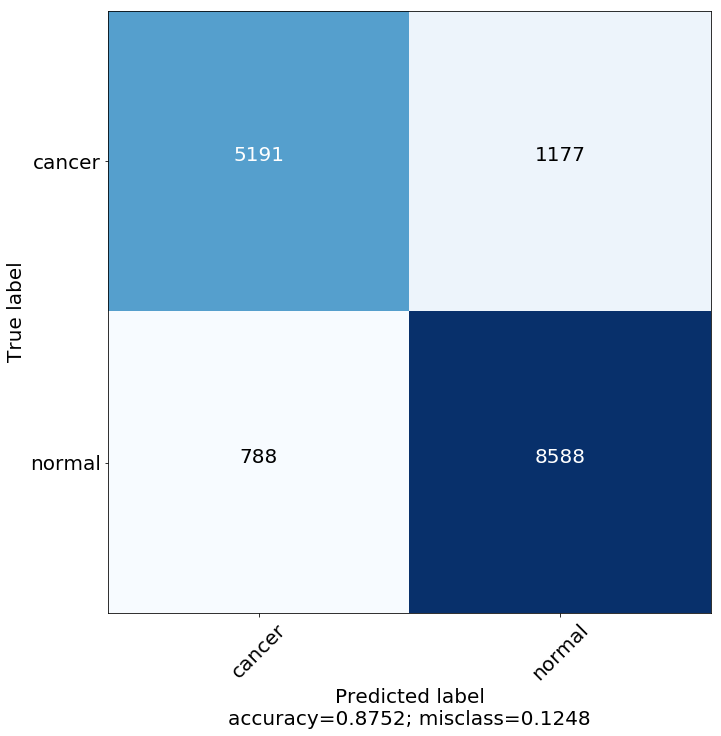

In [25]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[5191 1177]
 [ 788 8588]]
             precision    recall  f1-score   support

     cancer       0.87      0.82      0.84      6368
     normal       0.88      0.92      0.90      9376

avg / total       0.87      0.88      0.87     15744



In [27]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  86.82053855159725
Specificity :  87.94674859190988


In [28]:
print('roc_auc_score = ' + str(roc_auc_score(predictions, y_true)))

roc_auc_score = 0.8738364357175357


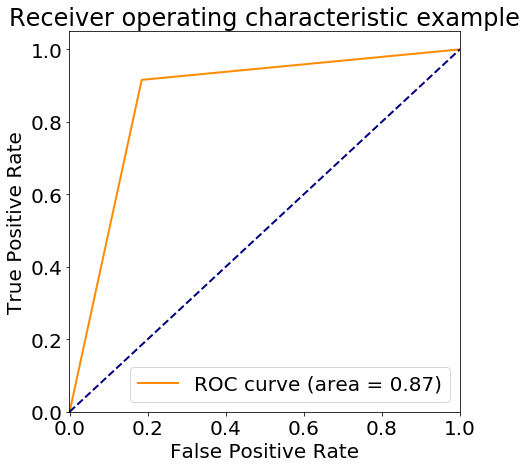

In [29]:
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-.001, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [30]:
predict = model.predict_proba(test_data, batch_size=batch_size, verbose=1)

15744/15744 [==============================] - 0s 25us/step


In [31]:
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y = label_binarize(test_labels, classes=[0, 1])
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [32]:
from scipy import interp
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

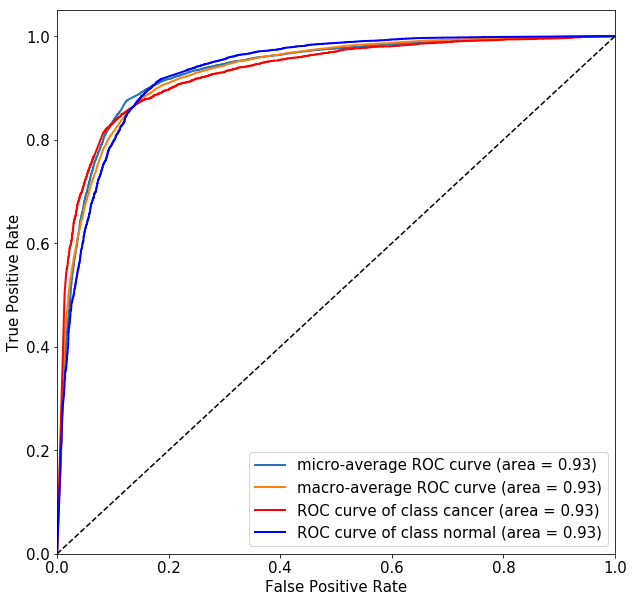

In [33]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from itertools import cycle
classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)
    

plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)
plot_name = 'no variation'
colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [34]:
tn, fp, fn, tp = cm.ravel()

In [35]:
print("Accuracy:",(tp+tn)/(tp+tn+fp+fn))
print("Precision:",(tp/(tp+fp)))
print("Recall:",(tp/(tp+fn)))
print("tp:", tp) 
print("fp:", fp) 
print("tn:",tn) 
print("fn:",fn)

Accuracy: 0.8751905487804879
Precision: 0.8794674859190988
Recall: 0.9159556313993175
tp: 8588
fp: 1177
tn: 5191
fn: 788


In [36]:
print('F1 score:', f1_score(y_true, y_pred))

F1 score: 0.8973407867927485


In [37]:
recall = (tp/(tp+fn))
precision=(tp/(tp+fp))

f1 = 2 / ( (1/recall) + (1 / precision))
print('F1 score:', f1)

F1 score: 0.8973407867927485


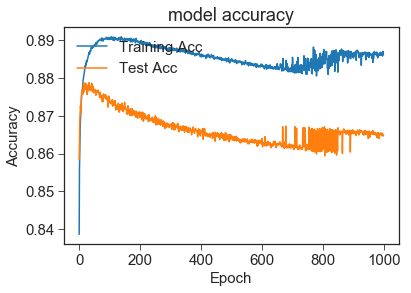

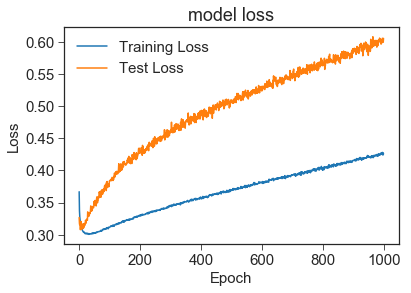

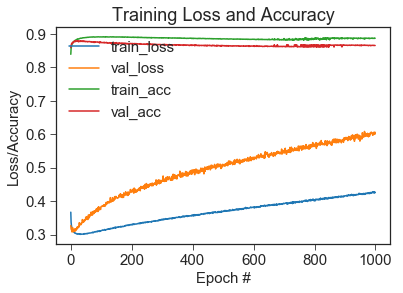

In [38]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")